In [2]:
import pandas as pd
import numpy as np

import pymc3 as pm
import arviz as az
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns
import pygal
from IPython.display import SVG, display

from sklearn.metrics import mean_absolute_percentage_error as mape

import warnings
warnings.filterwarnings('ignore')

In [3]:
from helper import *

In [4]:
mediaFile = "proactiv_usa_march23.csv"
dfMedia = pd.read_csv(mediaFile).drop(columns=["holiday"]).set_index("Day")
dfMedia.head()

,Amazon_Prospecting_MediaCost,BingSearch_PaidSearchBrand_MediaCost,BingSearch_PaidSearchNonBrand_MediaCost,BingSearch_ShoppingAdsBrandNonBrand_MediaCost,CTV_Awareness_MediaCost,Criteo_Prospecting_MediaCost,Criteo_Retargeting_MediaCost,DV360_Prospecting_MediaCost,DV360_Retargeting_MediaCost,Facebook_MediaCost,...,Snapchat_ConversionsYoungAdults_Impressions,Snapchat_VideoViewsTeens_Impressions,Snapchat_VideoViewsYoungAdults_Impressions,TheTradeDesk_Prospecting_Impressions,TheTradeDesk_Retargeting_Impressions,Tinder_Prospecting_Impressions,Twitch_Prospecting_Impressions,YouTube_Prospecting_Impressions,YouTube_Retargeting_Impressions,Orders
Day,,,,,,,,,,,,,,,,,,,,,
2021-03-01,0.0,399.43,52.02,170.28,0.0,0.0,0.0,0.0,0.0,14928.510004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87163.0,24346.0,780
2021-03-02,0.0,356.26,51.91,149.57,0.0,0.0,0.0,0.0,0.0,20888.419999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83037.0,30554.0,769
2021-03-03,0.0,418.41,37.60,185.69,0.0,0.0,0.0,0.0,0.0,18174.119989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93431.0,31253.0,797
2021-03-04,0.0,363.64,35.39,135.36,0.0,0.0,0.0,0.0,0.0,16527.890004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84057.0,35405.0,741
2021-03-05,0.0,403.17,42.96,127.99,0.0,0.0,0.0,0.0,0.0,21044.740017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60483.0,33950.0,706


In [6]:
dfMedia = dfMedia[get_media_vars(dfMedia) + ["Orders"]]

In [7]:
dfMediaCombined = pd.DataFrame()
fringe = set([])
cols = sorted(dfMedia.columns.values)
for col in get_media_vars(dfMedia):
    short = shorten_f_name(col)
    if short in fringe:
        dfMediaCombined[f"{short}_media_cost".lower()] += dfMedia[col]
    else:
        dfMediaCombined[f"{short}_media_cost".lower()] = dfMedia[col]
    fringe.add(col)

In [8]:
dfMediaCombined["orders"] = dfMedia.Orders

In [9]:
dfMediaCombined.isna().sum()

amazon_media_cost          0
bingsearch_media_cost      0
ctv_media_cost             0
criteo_media_cost          0
dv360_media_cost           0
facebook_media_cost        0
googlesearch_media_cost    0
influential_media_cost     0
lineartv_media_cost        0
pinterest_media_cost       0
radio_media_cost           0
snapchat_media_cost        0
thetradedesk_media_cost    0
tinder_media_cost          0
twitch_media_cost          0
youtube_media_cost         0
orders                     0
dtype: int64

checking model assumptions

In [10]:
to_keep = ["amazon_media_cost", "bingsearch_media_cost", "facebook_media_cost", "youtube_media_cost"]
dfMediaCombined = dfMediaCombined[to_keep + ["orders"]]

In [11]:
high = 0
threshold = 0.3
n = dfMediaCombined.shape[1]
for i in range(0, n):
    for j in range(i+1, n):
        if i != j:
            col1, col2 = dfMediaCombined.iloc[:, i], dfMediaCombined.iloc[:, j]
            r = np.corrcoef(col1, col2)[0][1]
            if abs(r) >= threshold:
                high += 1      
print(f"{high} pairs of features out of {int(n*(n+1) / 2)} have correlation exceeding threshold={threshold}")

1 pairs of features out of 15 have correlation exceeding threshold=0.3


In [12]:
too_low = 0
percent_variance = 0.2 # threshold=20%
n = dfMediaCombined.shape[1]
features = []
for i in range(0, n):
    col = dfMediaCombined.iloc[:, i]
    stddev = np.std(col)
    if stddev < (percent_variance * np.mean(col)):
        too_low += 1
        features.append(dfMediaCombined.columns.values[i])
print(f"{too_low} features have insufficient variability")
features

0 features have insufficient variability


[]

## saturation and carryover

In [13]:
def saturate(x, a):
    """
        arbitrary saturation curve, parameters of this function must define saturation curve
    """
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    """
        same function as specified in google whitepaper
        usually use poission random variable for length
    """
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

def show(chart):
    display(SVG(chart.render(disable_xml_declaration=True)))

In [14]:
class BayesianMixModel:
    def __init__(self, country, target, metric=mape):
        """
            data: DataFrame containing both X and y
            target: (str) column in data that is the response variable
            metric: TBD
        """
        self.country = country
        self.target = target
        self.metric = metric
    
    def fit(self, X, y):
        """
            called immediately upon initialization of BayesianMixModel instance
            trains model
            X: channel media cost information
            y: response variable
        """
        
        self.X = X
        self.y = y
        
        with pm.Model() as mmm:
            channel_contributions = []
            
            data = pm.Data("data", self.X)
            
            for i, channel in enumerate(self.X.columns.values):
                coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
                sat = pm.Exponential(f'sat_{channel}', lam=1)
                car = pm.Beta(f'car_{channel}', alpha=2, beta=2)

                channel_data = data.get_value()[:, i]
                channel_contribution = pm.Deterministic(
                    f'contribution_{channel}',
                    coef * saturate(
                        carryover(
                            channel_data,
                            car
                        ),
                        sat
                    )
                )

                channel_contributions.append(channel_contribution)

            base = pm.Exponential('base', lam=0.0001)
            noise = pm.Exponential('noise', lam=0.0001)

            sales = pm.Normal(
                'sales',
                mu=sum(channel_contributions) + base,
                sigma=noise,
                observed=y
            )

            trace = pm.sample(return_inferencedata=True, tune=3000)
        
        self.mmm = mmm
        self.trace = trace
        
    def predict(self, X):
        """
            X: DataFrame
        """
        pm.set_data({"data" : X}, model=self.mmm)
        ppc_test = pm.sample_posterior_predictive(self.trace, model=self.mmm, samples=1000)
        p_test_pred = ppc_test["sales"].mean(axis=0)
        
        return p_test_pred
    
    def score(self, X, y):
        """
            X: DataFrame
            y: Series
        """
        if self.metric:
            return self.metric(self.predict(X), y)
        else:
            return mape(self.predict(X), y)

    
    def lineplot(self):
        """
            plots actual vs fitted time series on entire training set
        """
        means = self.predict(self.X)

        line_chart = pygal.Line(fill=False, height=500, width=1000, title="Model Fit Time Series", x_title="Day", 
                              y_title=f"{self.target}", explicit_size=True, show_legend=True, legend_at_bottom=False)
        line_chart.add('TRUE', self.y.values)
        line_chart.add("PREDICTION", means)
        show(line_chart)

    
    def scatterplot(self):
        """
            plots actual vs fitted time series on entire training set
        """
        scatterplot = pygal.XY(print_values=False, stroke=False, fill=False, height=500, width=1000, title="Model Predictions vs True Observations", x_title="actual", 
                                  y_title="predicted", explicit_size=True, show_legend=True, legend_at_bottom=True)
        
        x = self.y.values
        y = self.predict(self.X)

        scatterplot.add("data", [(x[i], y[i]) for i in range(len(x))])
        g = max(max(x), max(y))
        scatterplot.add("true = pred", [(0,0), (g, g)], stroke=True)
        show(scatterplot)
        
    
    
    
        
        
        

In [15]:
from sklearn.model_selection import train_test_split
X = dfMediaCombined.drop(columns=["orders"])
y = dfMediaCombined.orders
xtrain, xval, ytrain, yval = train_test_split(X,y, test_size=0.2, shuffle=False)

In [16]:
model = BayesianMixModel(country="USA", target="orders")
model.fit(xtrain, ytrain)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_youtube_media_cost, sat_youtube_media_cost, coef_youtube_media_cost, car_facebook_media_cost, sat_facebook_media_cost, coef_facebook_media_cost, car_bingsearch_media_cost, sat_bingsearch_media_cost, coef_bingsearch_media_cost, car_amazon_media_cost, sat_amazon_media_cost, coef_amazon_media_cost]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 105 seconds.
There were 421 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44750505225680776, but should be close to 0.8. Try to increase the number of tuning steps.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
There were 502 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3993512108684796, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


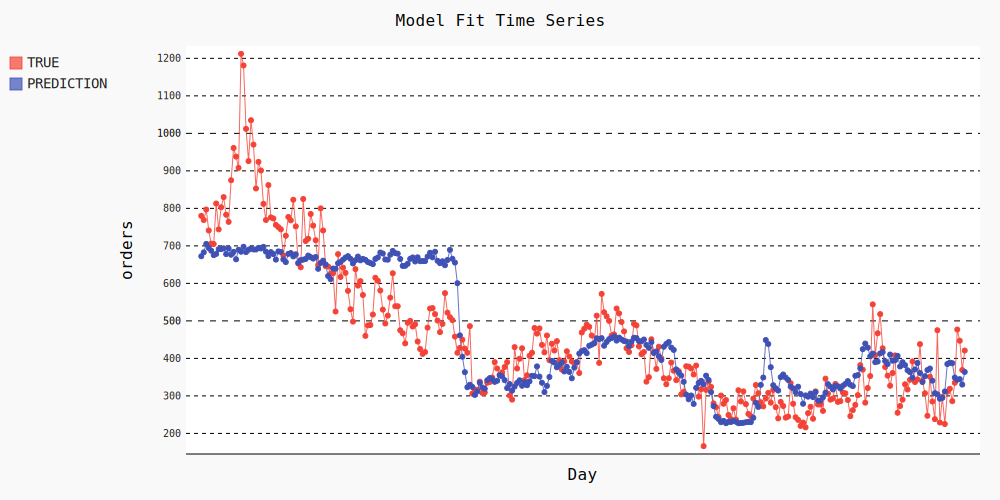

In [17]:
model.lineplot()

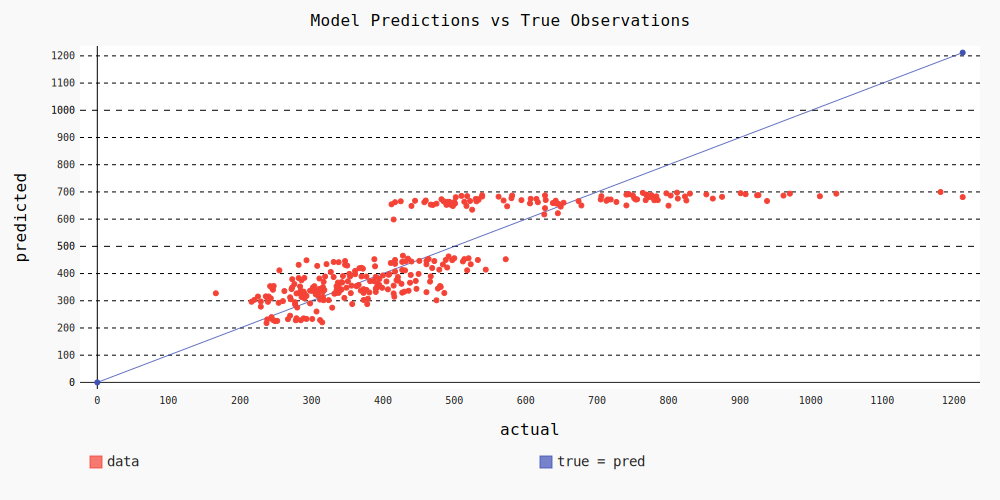

In [18]:
model.scatterplot()

In [19]:
pred = model.predict(xval)
score = model.score(xval, yval)

ValueError: Found input variables with inconsistent numbers of samples: [308, 77]